## Interactive single-objective Bayesian optimization

This notebook enables you to interactively optimize single-objective problems whose objective and constraint functions cannot be evaluated automatically, and is intended for use in problems with
* manual mesh generation and performance evaluation in computational fluid dynamics (CFD) and finite element analysis (FEA)
* experiment-based function evaluation where computational simulation is unavailable
* etc.

Copyright (c) 2022 Nobuo Namura  
This code is released under the MIT License, see LICENSE.txt.  
This Python code is for single-objective Bayesian optimization (SBO) with/without constraint handling.

### 0. Import
You need to install packages in requirement.txt by "pip install -r requirements.txt"

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
import shutil
from bo import BayesianOptimization
import test_problem

### 1. Setup

#### Problem definition  
You need to edit here for solving your problem

In [2]:
# Edit here! -----------------------------------------------------------------
f_design_space = 'design_space_branin.csv'     # File name (box constraints for design variables)
f_sample = 'sample_branin.csv'                 # File name (training data)
n_add = 3                                      # Number of additional sample points to be generated
# ----------------------------------------------------------------------------

# File read
df_design_space = pd.read_csv(f_design_space)  # File read
df_sample = pd.read_csv(f_sample)              # File read
nf = df_sample.columns.str.contains('f').sum() # Number of objective functions
ng = df_sample.columns.str.contains('g').sum() # Number of constraint functions where g <= 0 is satisfied for feasible solutions
nx = df_sample.columns.str.contains('x').sum() # Number of design variables
ns = len(df_sample)                            # Number of sample points

# Edit here if your problem include maximization or noisy function! ----------
MIN = np.full(nf, True)                        # True=Minimization, False=Maximization for each objective function
NOISE = np.full(nf+ng, False)                  # Use True if functions are noisy (Griewank, Rastrigin, DTLZ1, etc.) for each objective function
# ----------------------------------------------------------------------------

#### Parameter definition  
You do not need to edit here if you are not familier with Bayesian optimization and evolutionary computation

In [3]:
CRITERIA = 'EI'                                # EI, GP-MI, Error, or Estimation
npop_ea = 100                                  # Number of population in GA
ngen_ea = 200                                  # Number of generation in GA

### 2. Initialization

In [4]:
gp = BayesianOptimization(df_sample, df_design_space, MIN)

### 3. Model training: likelihood maximization with genetic algorithm (GA)
* theta0: hyperparameters in Kriging models have values in (0, 10**theta0]
* npop: number of population in GA
* ngen: maximum number of generation in GA
* mingen: minimum number of generation in GA
* STOP: True=training will be terminated if convergence condition is satisfied before ngen
* PRINT: True=print GA log
* theta: optimized hyperparameters (output)

In [5]:
warnings.simplefilter('ignore')
theta = gp.training(theta0 = 3.0, npop = 500, ngen = 500, mingen=0, STOP=True, NOISE=NOISE, PRINT=False)
gp.construction(theta)

--- 1-th function estimation -------------------


### 4. Additional sample generation: acquisition function maximization with GA

In [6]:
x_add, f_add_est, g_add_est = gp.optimize_single_objective_problem(CRITERIA=CRITERIA, n_add=n_add, npop_ea=npop_ea, ngen_ea=ngen_ea, PRINT=False, RETRAIN=True, theta0=3.0, npop=100, ngen=100, mingen=0, STOP=True)
add_sample = pd.DataFrame(np.hstack([x_add, f_add_est, g_add_est]), columns=np.hstack(['x'+np.arange(1,1+gp.nx).astype(str).astype(object), 'f'+np.arange(1,1+gp.nf).astype(str).astype(object), 'g'+np.arange(1,1+gp.ng).astype(str).astype(object)]))
add_sample

--- 1-th function estimation -------------------
--- 1-th function estimation -------------------


,x1,x2,f1
0,0.074243,1.00000,14.327737
1,0.969937,0.15534,-0.568566
2,0.574904,0.00000,5.515378


### 5. Visualization (2 variable case)

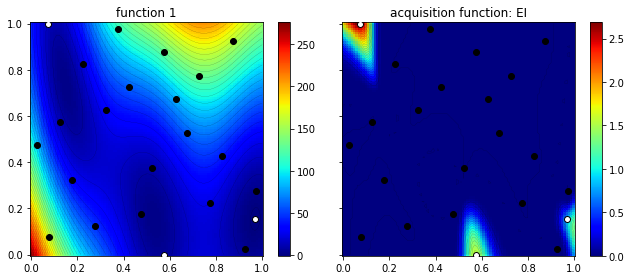

In [7]:
if nx == 2:
    fig, ax = plt.subplots(1, nf+ng+1, figsize=(4.5*(nf+ng+1),4), tight_layout=True, sharex='all', sharey='all')
    x = gp.xmin[0]+np.linspace(0, 1, 101)*(gp.xmax[0]-gp.xmin[0])
    y = gp.xmin[1]+np.linspace(0, 1, 101)*(gp.xmax[1]-gp.xmin[1])
    X, Y = np.meshgrid(x, y)
    F = np.zeros(np.shape(X))
    EI = np.zeros(np.shape(X))
    for k in range(nf+ng):
        for i in range(len(X[:,0])):
            for j in range(len(X[0,:])):
                F[i,j], S = gp.estimation(np.array([X[i,j],Y[i,j]]), nfg=k)
                if k==0:
                    if CRITERIA=='EI' or CRITERIA=='Error':
                        EI[i,j] = -1*gp.acquisition_function(np.array([X[i,j],Y[i,j]]))
                    elif CRITERIA=='GP-MI' or CRITERIA=='Estimation':
                        EI[i,j] = np.where(MIN, 1, -1)*gp.acquisition_function(np.array([X[i,j],Y[i,j]]))
        ax[k].set_title('function '+str(k+1))
        ax[k].scatter(gp.x[:,0], gp.x[:,1], c='black', zorder=3)
        ax[k].scatter(x_add[:,0], x_add[:,1], c='white', edgecolor='black', zorder=4)
        pcm = ax[k].pcolor(X, Y, F, cmap='jet', shading='auto', zorder=1)
        fig.colorbar(pcm, ax=ax[k])
        ax[k].contour(X, Y, F, 40, colors='black', linestyles='solid', linewidths=0.1, zorder=2)

        if k==0:
            ax[-1].set_title('acquisition function: ' + CRITERIA)
            ax[-1].scatter(gp.x[:,0], gp.x[:,1], c='black', zorder=3)
            ax[-1].scatter(x_add[:,0], x_add[:,1], c='white', edgecolor='black', zorder=4)
            pcm = ax[-1].pcolor(X, Y, EI, cmap='jet', shading='auto', vmin=0, zorder=1)
            fig.colorbar(pcm, ax=ax[-1])
            ax[-1].contour(X, Y, EI, 40, colors='black', linestyles='solid', linewidths=0.1, zorder=2)

### 6. File output
* Evaluate objective functions of the lowest n_add sample points and overwrite the generated file
* Return to "1. Setup" and use the file as "f_sample" for the next iteration

In [8]:
path, extension = os.path.splitext(f_sample)
f_sample_out =  path + '_' + str(gp.ns+n_add) + extension
shutil.copyfile(f_sample, f_sample_out)
with open(f_sample_out, 'a') as file:
    np.savetxt(file, x_add, delimiter=',')

### Appendix: objective function evaluation for the sample problem in "sample_branin.csv"
* You can evaluate the objective functions and update the file generated at "6. File output"
* Automatic iteration can be executed with **main.py**

In [9]:
f_add = np.array([test_problem.Branin(x_add[i,:]) for i in range(n_add)])
path, extension = os.path.splitext(f_sample)
f_sample_sgm =  path + '_' + str(gp.ns+n_add) + '_evaluated' + extension
shutil.copyfile(f_sample, f_sample_sgm)
with open(f_sample_sgm, 'a') as file:
    np.savetxt(file, np.hstack([x_add, f_add]), delimiter=',')